# Concise Text Classification Exploration

## Data:

Medical text classification [dataset](https://www.kaggle.com/jsreddy79/text-classification-supervised-learning#TextClassification_Data.csv). 

In [551]:
import pandas as pd
import csv
import collections
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import random
import math
import string
import itertools
import tensorflow as tf
from sklearn.manifold import TSNE
import time
import copy

In [428]:
pre_data = pd.read_csv('Loves_Consult//TextClassification_Data.csv', encoding = "ISO-8859-1")
pre_data.head()

,fileid,SUMMARY,DATA,categories,sub_categories,previous_appointment,ID
0,2015561331001,Pt aware that he needs ROV for refill,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,PRESCRIPTION,REFILL,No,2015_5_6133_1001
1,2015561341001,Mom wants to know if the Focalin needs some do...,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6134_1001
2,2015561351001,pt called to discuss nortryptiline. she says s...,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6135_1001
3,2015561361001,FYI Nortryptline medication.,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,MISCELLANEOUS,OTHERS,No,2015_5_6136_1001
4,2015561371001,Letter of patient establishment request,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,MISCELLANEOUS,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",No,2015_5_6137_1001


In [429]:
pre_data = pre_data[['SUMMARY', 'categories']].dropna()
pre_data.head()

,SUMMARY,categories
0,Pt aware that he needs ROV for refill,PRESCRIPTION
1,Mom wants to know if the Focalin needs some do...,ASK_A_DOCTOR
2,pt called to discuss nortryptiline. she says s...,ASK_A_DOCTOR
3,FYI Nortryptline medication.,MISCELLANEOUS
4,Letter of patient establishment request,MISCELLANEOUS


In [430]:
print(collections.Counter(pre_data['categories']))

Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11743, 'MISCELLANEOUS': 10460, 'LAB': 4246, 'JUNK': 20, 'mISCELLANEOUS': 3, 'asK_A_DOCTOR': 1})


In [431]:
def fix(data_frame):
    junk_list = list(data_frame[data_frame['categories'] == 'JUNK'].index)
    data_frame = data_frame.drop(junk_list, axis = 0)
    data_frame = data_frame.replace(['mISCELLANEOUS', 'asK_A_DOCTOR'], ['MISCELLANEOUS','ASK_A_DOCTOR'])
    return data_frame

pre_data = fix(pre_data)
print(collections.Counter(pre_data['categories']))

Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11744, 'MISCELLANEOUS': 10463, 'LAB': 4246})


# Balance Data

In [432]:
print(collections.Counter(pre_data['categories']))

Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11744, 'MISCELLANEOUS': 10463, 'LAB': 4246})


In [433]:
# Owed:
# def max_balance()
# add x_step paramter to regression balance.

def simple_list_regression(list_of_values):
    list_of_values.sort()
    y = list_of_values
    x_n = len(y)-1
    x_bar = sum(range(len(y)))/len(y)
    y_bar = sum(y)/len(y)
    beta_numerator = sum([(i - x_bar)*(y[i]-y_bar) for i in range(len(y))])
    beta_denominator = sum([(i-x_bar)*(i-x_bar) for i in range(len(y))])
    beta = beta_numerator/beta_denominator
    alpha = y_bar - beta*x_bar
    return (alpha, beta)

def regression_balance(data_frame, class_key, 
                       upsample = True, 
                       downsample = False,
                       halt_after_intersect = True,
                       randomize_output = True, 
                       replace = True,
                       random_state = None):
    
    class_counter = collections.Counter(data_frame[class_key])
    count_keys = list(class_counter.keys())
    count_keys.reverse()
    count_list = list(class_counter.values())
    count_list.reverse()
    reg_coeff = simple_list_regression(count_list)
    intersect = 0
    for i in range(len(count_keys)):
        key = count_keys[i]
        difference = int(math.floor(reg_coeff[1]*i+reg_coeff[0]))-count_list[i]
        
        if difference > 0 and upsample and intersect == 0:
            sample_data = data_frame[data_frame[class_key] == key].sample(n = difference, replace = replace, 
                                                                          random_state = random_state)
            data_frame = data_frame.append(sample_data, ignore_index = True)
        if difference == 0:
            continue
        elif difference < 0:
            if halt_after_intersect:
                intersect += 1
            if downsample:
                sample_data = data_frame[data_frame[class_key] == key].sample(n = -difference, replace = False, 
                                                                          random_state = random_state)
                drop_indices = list(sample_data.index)
                data_frame = data_frame.drop(drop_indices, axis = 0)
    if randomize_output:
        data_frame = data_frame.sample(frac=1).reset_index(drop=True)
    return data_frame

Regression Coefficients: (intercept, slope) = (6181.6, 2300.5)


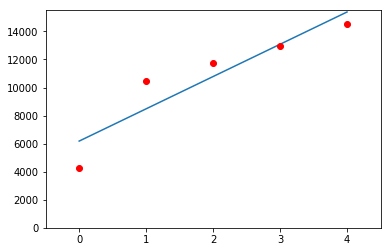

In [434]:
original_class_counts = list(collections.Counter(pre_data['categories']).values())
original_reg_coeff = simple_list_regression(original_class_counts)
print('Regression Coefficients: (intercept, slope) = '+ str(original_reg_coeff))
def f(x):
    return original_reg_coeff[1]*x + original_reg_coeff[0]
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 4, 1000)
ax.plot(x, f(x))

original_class_counts.sort()
plt.plot(range(len(original_class_counts)),original_class_counts,'ro')
plt.axis([-0.5, 4.5, 0, max(original_class_counts)+1000])
plt.show()

In [435]:
balanced_data = regression_balance(pre_data, class_key = 'categories')

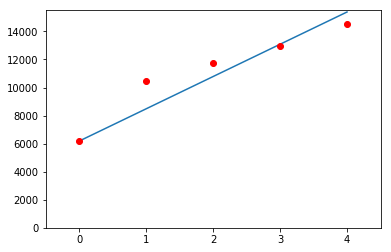

In [436]:
class_counts = list(collections.Counter(balanced_data['categories']).values())

def f(x):
    return original_reg_coeff[1]*x + original_reg_coeff[0]
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 4, 1000)
ax.plot(x, f(x))
class_counts.sort()
plt.plot(range(len(class_counts)),class_counts,'ro')
plt.axis([-0.5, 4.5, 0, max(class_counts)+1000])
plt.show()

# Data Formatting

In [437]:
data_array = balanced_data.values[...,0]
labels_array = balanced_data.values[...,1]

### Encoding Labels

In [450]:
def encode_labels(labels):
    unique_labels = np.unique(labels)
    identity = (unique_labels == unique_labels[:,None]).astype(np.float32)
    lookup_dict = dict(zip(unique_labels.tolist(), [identity[i] for i in range(identity.shape[0])]))
    out_labels = (unique_labels == labels[:,None]).astype(np.float32)
    def lookup_function(label):
        return lookup_dict[label]
    def reverse_lookup_function(encoded_label):
        rev_look = [x for x,y in lookup_dict.items() if np.array_equal(y, encoded_label)]
        return rev_look[0]
    def decode_labels(encoded_label_array):
        return np.array([reverse_lookup_function(encoded_label_array[i]) for i in range(encoded_label_array.shape[0])])
    def print_stats():
        if np.array_equal(decode_labels(out_labels), labels):
            print('Successful label encoding.')
            print('Number of classes: ' + str(unique_labels.shape[0]))
            print('Number of labels: ' + str(out_labels.shape[0]))
        else:
            print('Bijection failure.')
    print_stats()
    return out_labels, lookup_function, reverse_lookup_function, decode_labels

labels, label2vec, vec2label, decode_labels = encode_labels(labels_array)

Successful label encoding.
Number of classes: 5
Number of labels: 55848


## Word Embedding: Internal Corpus Word2Vec

### Corpus Construction and Frequency Encoding

In [129]:
stop_list = [".",",","!","?",":",";","/","(",")","-", "\ufeff", "\"", "\'s"]
end_signature = '[..end..]'

# Owed: use number before 'mg' and space after to split 'mg' from drug measurements.

def format_string(string):
    global stop_list
    for item in stop_list:
        string = string.replace(item, " " + item + " ")
    return string.lower()

def strings2list(column, report = True, n_most_common = 20):
    # input: 1D numpy array of strings.
    # output: list of words, spaced punctuation, and end token.
    global puncuation
    global end_signature
    out_list = []
    for i in range(column.shape[0]):
        if isinstance(column[i], str):
            instance_list = format_string(column[i]).split() + [end_signature]
            out_list = out_list + instance_list
        else:
            print('Entry not a string at index ' + str(i))
    frequency_dictionary = collections.Counter(out_list)
    dictionary = dict()
    for word, _ in frequency_dictionary.most_common():
        dictionary[word] = len(dictionary) 
    def print_stats():
        print(str(len(out_list)) + " instances across " + str(len(frequency_dictionary)) + " distinct.")
        print("%d most common words: " % n_most_common, end = "")
        print(dict(frequency_dictionary.most_common(n_most_common)))
    if report:
        print_stats()
    reverse_dictionary = dict(zip(dict(dictionary).values(), dict(dictionary).keys()))
    return out_list, dictionary, reverse_dictionary, dict(frequency_dictionary)

words_list, dictionary, reverse_dictionary, frequency_dictionary = strings2list(data_array, n_most_common = 1000)

418276 instances across 10789 distinct.
1000 most common words: {'[..end..]': 55848, '/': 17880, 'to': 11879, 'pt': 11109, 'rx': 8704, '-': 8304, '.': 6843, ',': 5724, 'for': 5713, 'appt': 4671, ':': 4648, 'phone': 4067, 'request': 4048, 'note': 3993, 'refill': 3706, 'on': 3472, 'mri': 3386, 'call': 3288, '15': 3131, 'with': 3111, 'and': 3060, 'results': 3038, 'in': 2492, 'rov': 2324, 'a': 2164, 'dr': 2098, "'s": 2063, 'of': 2038, 'please': 1890, 'mom': 1701, 'the': 1620, '?': 1618, 'clld': 1614, 'from': 1586, 'order': 1478, 'scheduled': 1432, 'w': 1406, 'needs': 1402, 'called': 1399, 'patient': 1396, 'about': 1389, '1': 1339, 'calling': 1294, '2015': 1283, 'is': 1268, 'new': 1266, 'rn': 1249, '2': 1240, 'at': 1205, 'like': 1199, '3': 1181, 'would': 1169, '@': 1113, 'add': 1105, 'requesting': 1099, 'work': 1082, 'wants': 1073, 'pa': 1067, 'today': 1034, 'pls': 1004, 'not': 1002, 'need': 987, 'discuss': 960, 'records': 951, 'sch': 947, 'faxed': 946, '6': 942, 'eeg': 936, 'referral': 931

Note: The dataset may not be large enough for meaningful relations to be developed.  A larger corpus of loose medical notes probably should be mined for more meaningful relations in production. Additionally, a larger corpus would be needed beyond the closed classification problem for unexpected values. 

In [130]:
numerically_encoded_corpus = [dictionary[word] for word in words_list]
for number in numerically_encoded_corpus[:100]:
    print(reverse_dictionary[number], end = " ")
del words_list

scheduled [..end..] faxed ref and recs to dr conder [..end..] 5 / 29 wcb - eeg results [..end..] prism over left eye solved " moving objects " problem [..end..] 18yo added on to dr wyant this pm [..end..] please sign off med [..end..] diastat pa - waiting for contact info from mom via portal [..end..] krystal rn at wake med called about admtiting pt for sz [..end..] provigil rxrf [..end..] rxrf trokendi [..end..] migraine medicine [..end..] triage - possible med side effect [..end..] unable to reach [..end..] zolpidem refill request [..end..] dtr called to rsc appt for 4 / 15 

## Embedding Model

In [141]:
data_index = 0
left_right_index = [0,0]
subsample_words = []

def subsample_keep_probability(frequency_ratio, parameter = 0.001):
    return min(1, (math.sqrt(frequency_ratio/parameter)+1))

def generate_batch_end_acknowledging_skipgram(corpus, 
                                              batch_size = None, 
                                              n_left = 2, 
                                              n_right = 2,
                                              subsample = True):
    global end_signature
    global data_index
    global left_right_index
    global subsample_words
    corpus_size = len(corpus)
    assert isinstance(batch_size, int), "Batch Generator: You must specify a batch size."
    batch = np.ndarray(shape=(batch_size), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype = np.int32)
    record_position = 0
    word_recorded = False
    corpus_size = len(corpus)
    while record_position < batch_size:
        if subsample and corpus[data_index] in subsample_words:
            data_index = (data_index + 1) % corpus_size
            continue
        # Record end signature with identity and move on.
        if corpus[data_index] == dictionary[end_signature]:
            batch[record_position] = corpus[data_index]
            labels[record_position] = corpus[data_index]
            record_position += 1
            data_index = (data_index + 1) % corpus_size
            word_recorded = False
            continue
            
        # Look left.
        for i in range(left_right_index[0], n_left):
            if record_position == batch_size:
                break
            if corpus[data_index - 1 - i] == dictionary[end_signature]:
                break
            if subsample == True and corpus[data_index-1-i] in subsample_words:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index - 1 - i]
                word_recorded = True
                left_right_index[0] += 1
                record_position += 1
                
        # Look right.
        for i in range(left_right_index[1], n_right):
            # print(str(left_right_index[1])+' '+str(n_right))
            if record_position == batch_size:
                break
            if corpus[data_index + 1 + i] == dictionary[end_signature]:
                break
            if subsample and corpus[data_index+1+i] in subsample_words:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index + 1 + i]
                word_recorded = True
                left_right_index[1] += 1
                record_position += 1
                
        # Record lonely word with identity. 
        if not word_recorded:
            batch[record_position] = corpus[data_index]
            labels[record_position] = corpus[data_index]
            record_position += 1
        if record_position == batch_size:
            break
        # Subsampling decision. 
        if subsample:
            # Move this computation to corpus in future versions.
            frequency_ratio = frequency_dictionary[reverse_dictionary[corpus[data_index]]]/corpus_size 
            probability = subsample_keep_probability(frequency_ratio)
            sample = random.uniform(0,1)
            if sample > probability:
                subsample_words.append(corpus[data_index])
        data_index = (data_index + 1) % corpus_size
        word_recorded = False
        left_right_index = [0,0]
    return batch, labels

# Batch/Label example.
example_batch, example_labels = generate_batch_end_acknowledging_skipgram(numerically_encoded_corpus, 
                                                                          batch_size = 12)
for i in range(10):
    print(reverse_dictionary[numerically_encoded_corpus[i]], end = " ")
print(" ")
print(example_batch)
print(example_labels)
print('Batch 1: ', end = "")
print([reverse_dictionary[x] for x in example_batch])
print('Label 1: ', end = "")
print([reverse_dictionary[x] for x in example_labels.reshape(12)])

scheduled [..end..] faxed ref and recs to dr conder [..end..]  
[ 35   0  65  65 241 241 241  20  20  20  20 451]
[[ 35]
 [  0]
 [241]
 [ 20]
 [ 65]
 [ 20]
 [451]
 [241]
 [ 65]
 [451]
 [  2]
 [ 20]]
Batch 1: ['scheduled', '[..end..]', 'faxed', 'faxed', 'ref', 'ref', 'ref', 'and', 'and', 'and', 'and', 'recs']
Label 1: ['scheduled', '[..end..]', 'ref', 'and', 'faxed', 'and', 'recs', 'ref', 'faxed', 'recs', 'to', 'and']


In [142]:
vocabulary_size = len(dictionary)
embedding_size = 100
valid_size = 16
valid_examples = np.array(random.sample(range(100,200), valid_size))
number_negative_samples = 64
batch_size = 100

Word2Vec_graph = tf.Graph()

with Word2Vec_graph.as_default():
    # Input.
    # Note: Since this algorithm is a lookup of matrix rows, the data is simply
    # the indices of the rows to look up.
    train_data = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size,1])
    valid_data = tf.constant(valid_examples, dtype = tf.int32)
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size],
                                               minval = -1.0,
                                               maxval = 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev = 1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    sampled_softmax_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                               biases=softmax_biases, 
                               inputs=embed,
                               labels=train_labels, 
                               num_sampled=number_negative_samples, 
                               num_classes=vocabulary_size)
    
    loss = tf.reduce_mean(sampled_softmax_loss)
    
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Normalized embeddings.
    embedding_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings/embedding_norm
    
    # Validation on fixed validation data. 
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_data)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [153]:
number_of_iterations = int(1000*len(numerically_encoded_corpus)/batch_size)

with tf.Session(graph = Word2Vec_graph) as session:
    start_time = time.time()
    tf.global_variables_initializer().run()
    print('Variables Initialized')
    average_loss = 0
    for iteration in range(number_of_iterations):
        batch_data, batch_labels = generate_batch_end_acknowledging_skipgram(numerically_encoded_corpus,
                                                                            batch_size = batch_size)
        feed_dict = {train_data : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if iteration % 2000 == 0:
            average_loss = average_loss / 2000
            print('Average loss at iteration %d: %f' % (iteration, average_loss))
    Word2Vec_embeddings = normalized_embeddings.eval()
    print('Embedding complete.')
    end_time = time.time()
    print(end_time - start_time)

Variables Initialized
Average loss at iteration 0: 0.003587
Average loss at iteration 2000: 3.791565
Average loss at iteration 4000: 3.352444
Average loss at iteration 6000: 3.240718
Average loss at iteration 8000: 3.178018
Average loss at iteration 10000: 3.141759
Average loss at iteration 12000: 3.108676
Average loss at iteration 14000: 2.996484
Average loss at iteration 16000: 2.989352
Average loss at iteration 18000: 2.977206
Average loss at iteration 20000: 2.964292
Average loss at iteration 22000: 2.952698
Average loss at iteration 24000: 2.945905
Average loss at iteration 26000: 2.881381
Average loss at iteration 28000: 2.890042
Average loss at iteration 30000: 2.876078
Average loss at iteration 32000: 2.869656
Average loss at iteration 34000: 2.866831
Average loss at iteration 36000: 2.852750
Average loss at iteration 38000: 2.811774
Average loss at iteration 40000: 2.828962
Average loss at iteration 42000: 2.806858
Average loss at iteration 44000: 2.811693
Average loss at iter

Average loss at iteration 384000: 2.474827
Average loss at iteration 386000: 2.462269
Average loss at iteration 388000: 2.464175
Average loss at iteration 390000: 2.471672
Average loss at iteration 392000: 2.466795
Average loss at iteration 394000: 2.478460
Average loss at iteration 396000: 2.468591
Average loss at iteration 398000: 2.466073
Average loss at iteration 400000: 2.462422
Average loss at iteration 402000: 2.466897
Average loss at iteration 404000: 2.459576
Average loss at iteration 406000: 2.473394
Average loss at iteration 408000: 2.468467
Average loss at iteration 410000: 2.464036
Average loss at iteration 412000: 2.465569
Average loss at iteration 414000: 2.463144
Average loss at iteration 416000: 2.459592
Average loss at iteration 418000: 2.475952
Average loss at iteration 420000: 2.463480
Average loss at iteration 422000: 2.463955
Average loss at iteration 424000: 2.468726
Average loss at iteration 426000: 2.460098
Average loss at iteration 428000: 2.457715
Average los

Average loss at iteration 766000: 2.422748
Average loss at iteration 768000: 2.422905
Average loss at iteration 770000: 2.420658
Average loss at iteration 772000: 2.430911
Average loss at iteration 774000: 2.425457
Average loss at iteration 776000: 2.425513
Average loss at iteration 778000: 2.426534
Average loss at iteration 780000: 2.421963
Average loss at iteration 782000: 2.417857
Average loss at iteration 784000: 2.433292
Average loss at iteration 786000: 2.422506
Average loss at iteration 788000: 2.423382
Average loss at iteration 790000: 2.429163
Average loss at iteration 792000: 2.417517
Average loss at iteration 794000: 2.420924
Average loss at iteration 796000: 2.431950
Average loss at iteration 798000: 2.421271
Average loss at iteration 800000: 2.424172
Average loss at iteration 802000: 2.418728
Average loss at iteration 804000: 2.416988
Average loss at iteration 806000: 2.419830
Average loss at iteration 808000: 2.428458
Average loss at iteration 810000: 2.425793
Average los

Average loss at iteration 1144000: 2.404239
Average loss at iteration 1146000: 2.404804
Average loss at iteration 1148000: 2.397382
Average loss at iteration 1150000: 2.420136
Average loss at iteration 1152000: 2.403267
Average loss at iteration 1154000: 2.405828
Average loss at iteration 1156000: 2.407495
Average loss at iteration 1158000: 2.401891
Average loss at iteration 1160000: 2.399198
Average loss at iteration 1162000: 2.413674
Average loss at iteration 1164000: 2.401556
Average loss at iteration 1166000: 2.401608
Average loss at iteration 1168000: 2.409863
Average loss at iteration 1170000: 2.400114
Average loss at iteration 1172000: 2.400189
Average loss at iteration 1174000: 2.405593
Average loss at iteration 1176000: 2.407879
Average loss at iteration 1178000: 2.404277
Average loss at iteration 1180000: 2.407339
Average loss at iteration 1182000: 2.398767
Average loss at iteration 1184000: 2.404921
Average loss at iteration 1186000: 2.406733
Average loss at iteration 118800

Average loss at iteration 1518000: 2.388640
Average loss at iteration 1520000: 2.389682
Average loss at iteration 1522000: 2.394230
Average loss at iteration 1524000: 2.387999
Average loss at iteration 1526000: 2.390747
Average loss at iteration 1528000: 2.399809
Average loss at iteration 1530000: 2.389610
Average loss at iteration 1532000: 2.393211
Average loss at iteration 1534000: 2.392655
Average loss at iteration 1536000: 2.384519
Average loss at iteration 1538000: 2.392376
Average loss at iteration 1540000: 2.394356
Average loss at iteration 1542000: 2.391945
Average loss at iteration 1544000: 2.396198
Average loss at iteration 1546000: 2.394213
Average loss at iteration 1548000: 2.387201
Average loss at iteration 1550000: 2.397332
Average loss at iteration 1552000: 2.392721
Average loss at iteration 1554000: 2.384736
Average loss at iteration 1556000: 2.393528
Average loss at iteration 1558000: 2.398265
Average loss at iteration 1560000: 2.387211
Average loss at iteration 156200

Average loss at iteration 1892000: 2.384338
Average loss at iteration 1894000: 2.396209
Average loss at iteration 1896000: 2.383121
Average loss at iteration 1898000: 2.384567
Average loss at iteration 1900000: 2.384464
Average loss at iteration 1902000: 2.377816
Average loss at iteration 1904000: 2.383511
Average loss at iteration 1906000: 2.387840
Average loss at iteration 1908000: 2.381525
Average loss at iteration 1910000: 2.386859
Average loss at iteration 1912000: 2.385643
Average loss at iteration 1914000: 2.381149
Average loss at iteration 1916000: 2.386448
Average loss at iteration 1918000: 2.386206
Average loss at iteration 1920000: 2.378872
Average loss at iteration 1922000: 2.380255
Average loss at iteration 1924000: 2.391054
Average loss at iteration 1926000: 2.389566
Average loss at iteration 1928000: 2.385020
Average loss at iteration 1930000: 2.387861
Average loss at iteration 1932000: 2.381415
Average loss at iteration 1934000: 2.380092
Average loss at iteration 193600

Average loss at iteration 2266000: 2.380885
Average loss at iteration 2268000: 2.375238
Average loss at iteration 2270000: 2.379687
Average loss at iteration 2272000: 2.378742
Average loss at iteration 2274000: 2.374220
Average loss at iteration 2276000: 2.376971
Average loss at iteration 2278000: 2.384254
Average loss at iteration 2280000: 2.371051
Average loss at iteration 2282000: 2.380702
Average loss at iteration 2284000: 2.382004
Average loss at iteration 2286000: 2.371147
Average loss at iteration 2288000: 2.372019
Average loss at iteration 2290000: 2.385039
Average loss at iteration 2292000: 2.376409
Average loss at iteration 2294000: 2.374875
Average loss at iteration 2296000: 2.381475
Average loss at iteration 2298000: 2.372665
Average loss at iteration 2300000: 2.375915
Average loss at iteration 2302000: 2.388694
Average loss at iteration 2304000: 2.377286
Average loss at iteration 2306000: 2.374194
Average loss at iteration 2308000: 2.381841
Average loss at iteration 231000

Average loss at iteration 2640000: 2.366377
Average loss at iteration 2642000: 2.372558
Average loss at iteration 2644000: 2.376294
Average loss at iteration 2646000: 2.372747
Average loss at iteration 2648000: 2.371428
Average loss at iteration 2650000: 2.376907
Average loss at iteration 2652000: 2.368480
Average loss at iteration 2654000: 2.370408
Average loss at iteration 2656000: 2.375341
Average loss at iteration 2658000: 2.371073
Average loss at iteration 2660000: 2.374465
Average loss at iteration 2662000: 2.373320
Average loss at iteration 2664000: 2.370546
Average loss at iteration 2666000: 2.370444
Average loss at iteration 2668000: 2.380151
Average loss at iteration 2670000: 2.368812
Average loss at iteration 2672000: 2.367391
Average loss at iteration 2674000: 2.378236
Average loss at iteration 2676000: 2.365982
Average loss at iteration 2678000: 2.367374
Average loss at iteration 2680000: 2.381253
Average loss at iteration 2682000: 2.370750
Average loss at iteration 268400

Average loss at iteration 3014000: 2.367437
Average loss at iteration 3016000: 2.374855
Average loss at iteration 3018000: 2.361131
Average loss at iteration 3020000: 2.365527
Average loss at iteration 3022000: 2.371911
Average loss at iteration 3024000: 2.367950
Average loss at iteration 3026000: 2.370492
Average loss at iteration 3028000: 2.375986
Average loss at iteration 3030000: 2.365124
Average loss at iteration 3032000: 2.367998
Average loss at iteration 3034000: 2.373819
Average loss at iteration 3036000: 2.365996
Average loss at iteration 3038000: 2.365781
Average loss at iteration 3040000: 2.374259
Average loss at iteration 3042000: 2.365359
Average loss at iteration 3044000: 2.363751
Average loss at iteration 3046000: 2.375372
Average loss at iteration 3048000: 2.366427
Average loss at iteration 3050000: 2.369440
Average loss at iteration 3052000: 2.373359
Average loss at iteration 3054000: 2.364821
Average loss at iteration 3056000: 2.363975
Average loss at iteration 305800

Average loss at iteration 3388000: 2.370072
Average loss at iteration 3390000: 2.361232
Average loss at iteration 3392000: 2.363617
Average loss at iteration 3394000: 2.367163
Average loss at iteration 3396000: 2.359243
Average loss at iteration 3398000: 2.356251
Average loss at iteration 3400000: 2.366572
Average loss at iteration 3402000: 2.362709
Average loss at iteration 3404000: 2.362046
Average loss at iteration 3406000: 2.371846
Average loss at iteration 3408000: 2.360256
Average loss at iteration 3410000: 2.359734
Average loss at iteration 3412000: 2.374084
Average loss at iteration 3414000: 2.362498
Average loss at iteration 3416000: 2.368585
Average loss at iteration 3418000: 2.368306
Average loss at iteration 3420000: 2.363339
Average loss at iteration 3422000: 2.356244
Average loss at iteration 3424000: 2.366110
Average loss at iteration 3426000: 2.358278
Average loss at iteration 3428000: 2.372749
Average loss at iteration 3430000: 2.364932
Average loss at iteration 343200

Average loss at iteration 3762000: 2.357745
Average loss at iteration 3764000: 2.360576
Average loss at iteration 3766000: 2.369064
Average loss at iteration 3768000: 2.358771
Average loss at iteration 3770000: 2.356350
Average loss at iteration 3772000: 2.367490
Average loss at iteration 3774000: 2.354818
Average loss at iteration 3776000: 2.356458
Average loss at iteration 3778000: 2.364758
Average loss at iteration 3780000: 2.359283
Average loss at iteration 3782000: 2.370104
Average loss at iteration 3784000: 2.361420
Average loss at iteration 3786000: 2.362681
Average loss at iteration 3788000: 2.356798
Average loss at iteration 3790000: 2.360084
Average loss at iteration 3792000: 2.353279
Average loss at iteration 3794000: 2.369625
Average loss at iteration 3796000: 2.359811
Average loss at iteration 3798000: 2.363091
Average loss at iteration 3800000: 2.354970
Average loss at iteration 3802000: 2.358029
Average loss at iteration 3804000: 2.357646
Average loss at iteration 380600

Average loss at iteration 4136000: 2.357971
Average loss at iteration 4138000: 2.363100
Average loss at iteration 4140000: 2.351754
Average loss at iteration 4142000: 2.352917
Average loss at iteration 4144000: 2.364362
Average loss at iteration 4146000: 2.356989
Average loss at iteration 4148000: 2.365513
Average loss at iteration 4150000: 2.362450
Average loss at iteration 4152000: 2.357628
Average loss at iteration 4154000: 2.353521
Average loss at iteration 4156000: 2.356104
Average loss at iteration 4158000: 2.359432
Average loss at iteration 4160000: 2.364129
Average loss at iteration 4162000: 2.361312
Average loss at iteration 4164000: 2.359766
Average loss at iteration 4166000: 2.355501
Average loss at iteration 4168000: 2.353429
Average loss at iteration 4170000: 2.349277
Average loss at iteration 4172000: 2.365740
Average loss at iteration 4174000: 2.354723
Average loss at iteration 4176000: 2.356551
Average loss at iteration 4178000: 2.361590
Average loss at iteration 418000

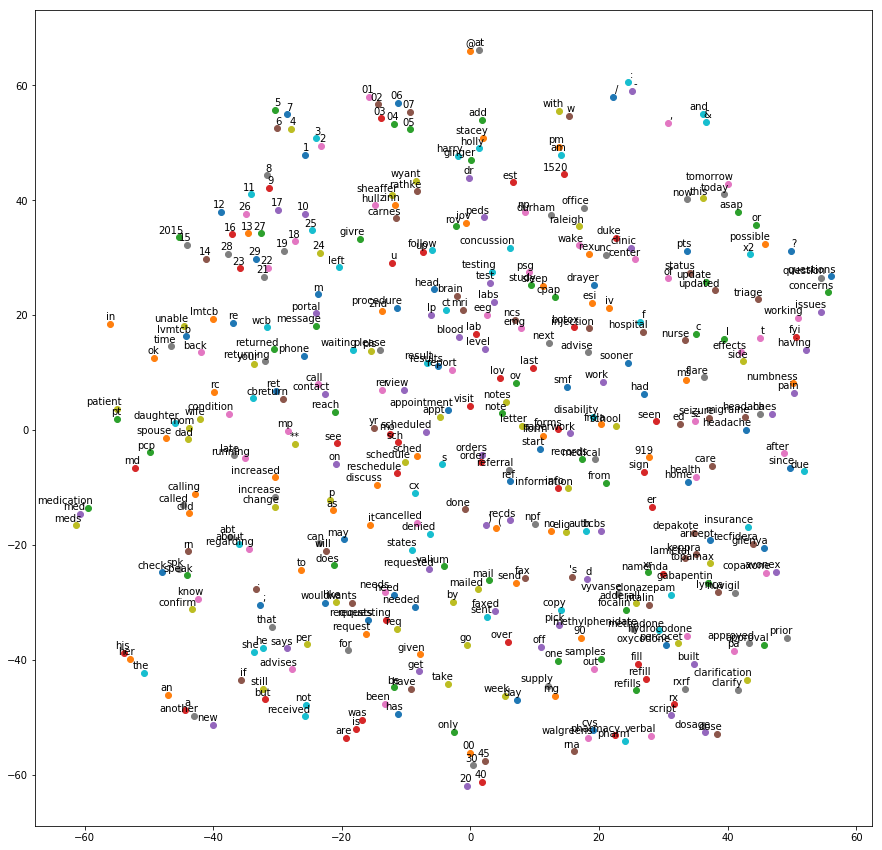

In [154]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(Word2Vec_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# Sequence Model

### Format Sequences for LSTM

Each string formatted as array of embedding lookup indices (integers). 

In [438]:
def format_data_LSTM(data):
    for i in range(len(data)):
        data[i] = np.array([dictionary[x] for x in format_string(data[i]).split()])
    return data

data_array = format_data_LSTM(data_array)

In [439]:
# Ensure data is not corrupted.

print(data_array[0])
for i in range(len(data_array[0])):
    print(reverse_dictionary[data_array[0][i]], end = " ")

[1239  462   68  101]
spanish neuropsych referral needed 

In [440]:
# Find max length of sequence in data.

max_length = 0
for i in range(len(data_array)):
    if len(data_array[i]) > max_length:
        max_length = len(data_array[i])
print(max_length)

28


In [441]:
# Add -1 to the dictionary as the null charater "" and modify the reverse dictionary accordingly.
dictionary[""] = -1
reverse_dictionary[-1] = ""

In [442]:
# Append the 0 vector to the end of Word2Vec_embeddings so that it is referenced for Word2Vec_embeddings[-1].
origin = np.zeros((embedding_size,))
Word2Vec_with_origin = np.append(Word2Vec_embeddings, np.array([origin]), axis = 0)
Word2Vec_with_origin[-1]
# Note: That another word was embedded at the origin is a "probability 0" event.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [443]:
data_array[:5]

array([array([1239,  462,   68,  101]), array([   3, 3522,   33, 3722]),
       array([11, 13]), array([1996, 1522,   10,   55,   22,   12]),
       array([  3,  44,  42,   8,  21,  27,  16,   6,   1, 709])],
      dtype=object)

In [444]:
for i in range(len(data_array)):
    difference = max_length - len(data_array[i])
    fill = np.full((1, difference), -1, dtype=int)
    data_array[i] = np.concatenate((fill, data_array[i]), axis = None)

data_array[:5]

array([array([  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1, 1239,  462,   68,  101]),
       array([  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,    3, 3522,   33, 3722]),
       array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, 11, 13]),
       array([  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
       1996, 1522,   10,   55,   22,   12]),
       array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,   3,  44,  42,   8,  21,  27,  16,   6,
         1, 709])], dtype=object)

In [451]:
# Another check against corruption. 
for i in range(len(data_array[0])):
    print(reverse_dictionary[data_array[0][i]], end = " ")
print("")
for i in range(len(data_array[1])):
    print(reverse_dictionary[data_array[1][i]], end = " ")
print("")    
for i in range(len(data_array[2])):
    print(reverse_dictionary[data_array[2][i]], end = " ")
print("")

                        spanish neuropsych referral needed 
                        pt suffering from constipation 
                          phone note 


## Balanced Train/Valid/Test Split

In [452]:
def train_valid_test_split(data_array, label_array, train_test_ratio = .85, train_valid_ratio = .85, shuffle_count = 7):
    labels = np.unique(label_array, axis = 0) # An array of the distinct entry values occuring in the argument.
    train_indices = []
    test_indices = []
    valid_indices = []
    for label in labels.tolist():
        label_indices = [i for i,x in enumerate(label_array) if np.array_equal(x, label)]
        instance_count = len(label_indices)
        train_test_partition = int(math.floor(train_test_ratio*instance_count))
        random.shuffle(label_indices)
        to_train_valid = label_indices[:train_test_partition]
        to_test = label_indices[train_test_partition:]
        test_indices = test_indices + to_test
        train_valid_partition = int(math.floor(train_valid_ratio*len(to_train_valid)))
        to_train = to_train_valid[:train_valid_partition]
        to_valid = to_train_valid[train_valid_partition:]
        train_indices = train_indices + to_train
        valid_indices = valid_indices + to_valid
    # The iterative shuffling is more an homage than a necessity, but I don't want to dig into
    # the pseudo randomness of random.shuffle.
    for i in range(shuffle_count):
        random.shuffle(train_indices)
        random.shuffle(valid_indices)
        random.shuffle(test_indices)
    train_data = data_array[train_indices]
    train_labels = label_array[train_indices]
    valid_data = data_array[valid_indices]
    valid_labels = label_array[valid_indices]
    test_data = data_array[test_indices]
    test_labels = label_array[test_indices]
    print("Train data shape: " + str(train_data.shape))
    print("Train labels shape: " + str(train_labels.shape))
    print("Valid data shape: " + str(valid_data.shape))
    print("Valid labels shape: " + str(valid_labels.shape))
    print("Test data shape: " + str(test_data.shape))
    print("Test labels shape: " + str(test_labels.shape))
    return train_data, train_labels, valid_data, valid_labels, test_data, test_labels

In [453]:
train_data, train_labels, valid_data, valid_labels, test_data, test_labels = train_valid_test_split(data_array, labels)

Train data shape: (40347,)
Train labels shape: (40347, 5)
Valid data shape: (7122,)
Valid labels shape: (7122, 5)
Test data shape: (8379,)
Test labels shape: (8379, 5)


## LSTM Model: Many-to-One

### LSTM Batch Generator

A batch is a 3-dimensional array to be unrolled along axis = 1 (columns). Numerically encoded sequence array is used to pull the Word2Vec embeddings, set along axis = 0. So in short, the batch is a matrix where each row corresponds to a sequence and each entry is a word in the sequence, but replaced by its vector embedding (100 dimensional Word2Vec representation). 

In [510]:
batch_size = 64
number_of_unrollings = max_length # Unroll the LSTM to account for longest sequence. 
number_of_classes = 5
data_index = 0

def generate_LSTM_batch(data_array, label_array, batch_size, number_of_unrollings, embedding_size):
    global data_index
    start = data_index
    batch = np.zeros(shape=(batch_size, number_of_unrollings, embedding_size), dtype=np.float32)
    labels = np.zeros(shape=(batch_size, number_of_classes), dtype=np.float32)
    for i in range(batch_size):
        batch[i] = Word2Vec_with_origin[data_array[data_index].astype(int)].reshape(1, number_of_unrollings, embedding_size)
        labels[i] = label_array[data_index]
        data_index = (data_index + 1) % len(data_array)
    return batch, labels

test_batch, test_label = generate_LSTM_batch(train_data, train_labels, batch_size, number_of_unrollings, embedding_size)
print(test_batch.shape)
print(test_label.shape)

valid_total, valid_total_labels = generate_LSTM_batch(valid_data, valid_labels, len(valid_data), number_of_unrollings, embedding_size)
test_total, test_total_labels = generate_LSTM_batch(test_data, test_labels, len(test_data), number_of_unrollings, embedding_size)
print(valid_total.shape)
print(test_total.shape)

(64, 28, 100)
(64, 5)
(7122, 28, 100)
(8379, 28, 100)


### LSTM Cell Math

The state equation: $s_{t}=\sigma(f)\bigodot s_{t-1} + \sigma(i)\bigodot\text{tanh}(c)$

The output equation: $o_{t}=\sigma(o)\bigodot\text{tanh}(s_{t})$

In [537]:
### Hyperparameters ###
number_of_nodes = 64
initial_learning_rate = 1.
#######################

Basic_LSTM_graph = tf.Graph()
with Basic_LSTM_graph.as_default():
    # Input
    T = tf.placeholder(tf.float32, shape = [batch_size, number_of_unrollings, embedding_size])
    Tlabel = tf.placeholder(tf.float32, shape = [batch_size, number_of_classes])
    V = tf.constant(valid_total)
    E = tf.constant(test_total)
    # Input gate and linear opertaion.
    X_i = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_i = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_i = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Forget gate and linear opertaion.
    X_f = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_f = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_f = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Memory cell and linear opertaion.                             
    X_c = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_c = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_c = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Output gate and linear opertaion..
    X_o = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_o = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_o = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    # Classifier weights and biases.
    W = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_classes], -0.1, 0.1))
    b = tf.Variable(tf.zeros([number_of_classes]))
    
    # Note: in LSTM cell, a sequence_element is batch_size many words at a time step in parallel. 
    def Basic_LSTM_cell(sequence_element, previous_output, state):
        input_gate = tf.sigmoid(tf.matmul(sequence_element, X_i) + tf.matmul(previous_output, M_i) + b_i)
        forget_gate = tf.sigmoid(tf.matmul(sequence_element, X_f) + tf.matmul(previous_output, M_f) + b_f)
        update = tf.matmul(sequence_element, X_c) + tf.matmul(previous_output, M_c) + b_c
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(sequence_element, X_o) + tf.matmul(previous_output, M_o) + b_o)
        return output_gate * tf.tanh(state), state

    # Unrolled LSTM loop.
    output = saved_output
    state = saved_state
    for i in range(number_of_unrollings):
        output, state = Basic_LSTM_cell(T[:,i], output, state)
    
    # Compute logits and loss for last step of LSTM.
    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
        L = tf.nn.xw_plus_b(output, W, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = Tlabel, logits=L))
    
    # Decaying learning rate for optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.AdagradOptimizer(learning_rate)    
    # Apply gradient clipping. 
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
    
    # Training predictions. 
    train_predict = tf.nn.softmax(L)
    
    # Valid predictions. 
    
    valid_saved_output = tf.Variable(tf.zeros([len(valid_total), number_of_nodes]), trainable = False)
    valid_saved_state = tf.Variable(tf.zeros([len(valid_total), number_of_nodes]), trainable = False)
    valid_output = valid_saved_output
    valid_state = valid_saved_state
    for i in range(number_of_unrollings):
        valid_output, valid_state = Basic_LSTM_cell(V[:,i], valid_output, valid_state)
    
    with tf.control_dependencies([valid_saved_output.assign(valid_output),
                                valid_saved_state.assign(valid_state)]):
        Lv = tf.nn.xw_plus_b(valid_output, W, b)
        valid_predict = tf.nn.softmax(Lv)
    
    # Test predictions. 
    
    test_output = tf.Variable(tf.zeros([len(test_total), number_of_nodes]), trainable = False)
    test_state = tf.Variable(tf.zeros([len(test_total), number_of_nodes]), trainable = False)
    for i in range(number_of_unrollings):
        test_output, test_state = Basic_LSTM_cell(E[:,i], test_output, test_state)
    test_predict = tf.nn.softmax(tf.nn.xw_plus_b(test_output, W, b))

In [538]:
def first_order_accuracy(predicted_labels, true_labels):
    return(100*np.sum(np.argmax(predicted_labels, 1)==np.argmax(true_labels, 1))
           /predicted_labels.shape[0])

def vanish_max_axis1(array):
    index = np.argmax(array, 1)
    for i in range(len(array)):
        array[i][index[i]] = 0
    return array

def second_order_accuracy(predicted_labels, true_labels):
    second_predicted_labels = vanish_max_axis1(predicted_labels)
    return(100*np.sum(np.argmax(second_predicted_labels, 1)==np.argmax(true_labels, 1))
           /predicted_labels.shape[0])

In [539]:
number_of_iterations = 10001
train_report_frequency = 500
valid_report_frequency = 2000
data_index = 0

with tf.Session(graph=Basic_LSTM_graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for iteration in range(number_of_iterations):
        batch_data, batch_labels = generate_LSTM_batch(train_data, 
                                                       train_labels, 
                                                       batch_size, 
                                                       number_of_unrollings, 
                                                       embedding_size)
        feed_dict = {T : batch_data, Tlabel : batch_labels}
        _, l, train_predictions, lr = session.run([optimizer, loss, train_predict, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if iteration % train_report_frequency == 0:
            mean_loss = mean_loss / train_report_frequency
            print('Iteration %d: average loss = %f, learning rate = %f' % (iteration, mean_loss, lr))
            mean_loss = 0
            train_acc1 = first_order_accuracy(train_predictions, batch_labels)
            train_acc2 = second_order_accuracy(train_predictions, batch_labels)
            print('First-order training accuracy = %.1f%%' % train_acc1)
            print('Second-order training accuracy = %.1f%%' % train_acc2)
            if iteration % 1000 == 0 and iteration > 0:
                valid_predictions = valid_predict.eval()
                valid_acc1 = first_order_accuracy(valid_predictions, valid_total_labels)
                valid_acc2 = second_order_accuracy(valid_predictions, valid_total_labels)
                print('First-order validation accuracy = %.1f%%.' % valid_acc1)
                print('Second-order validation accuracy = %.1f%%.' % valid_acc2)
    test_predictions = test_predict.eval()
    test_acc1 = first_order_accuracy(test_predictions, test_total_labels)
    test_acc2 = second_order_accuracy(test_predictions, test_total_labels)
    print('First-order test accuracy: %.1f%%' % test_acc1)
    print('Second-order test accuracy: %.1f%%' % test_acc2)
    print('Percent accuracy when first and second choice are counted: %.1f%%' % (test_acc1+test_acc2))

Initialized
Iteration 0: average loss = 0.003201, learning rate = 1.000000
First-order training accuracy = 40.6%
Second-order training accuracy = 15.6%
Iteration 500: average loss = 1.025601, learning rate = 1.000000
First-order training accuracy = 71.9%
Second-order training accuracy = 17.2%
Iteration 1000: average loss = 0.790003, learning rate = 1.000000
First-order training accuracy = 73.4%
Second-order training accuracy = 14.1%
First-order validation accuracy = 72.3%.
Second-order validation accuracy = 15.3%.
Iteration 1500: average loss = 0.737949, learning rate = 1.000000
First-order training accuracy = 78.1%
Second-order training accuracy = 14.1%
Iteration 2000: average loss = 0.702667, learning rate = 1.000000
First-order training accuracy = 71.9%
Second-order training accuracy = 12.5%
First-order validation accuracy = 74.2%.
Second-order validation accuracy = 14.5%.
Iteration 2500: average loss = 0.689843, learning rate = 1.000000
First-order training accuracy = 85.9%
Second-

# Bidirectional LSTM

We'll need to create an additional dataset for the reverse feed due to the untruncated vanishing problem. 

In [555]:
forward_data_array = copy.deepcopy(data_array)

[  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1 1239  462   68  101]
[  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1 1239  462   68  101]


In [542]:
def make_reverse_data_array(data_array):
    backward_data_array = copy.deepcopy(forward_data_array)
    return backward_data_array

array([  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1, 1239,  462,   68,  101])

In [557]:
forward_data_array[0] != -1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True])